Note: you may need to restart the kernel to use updated packages.
Loading cleaned data -> C:\Capstone Project DS Subhajit Nandy\Digital Marketing Campaign Conversion\data\digital_marketing_campaign_cleaned.csv
Data shape: (8000, 20)
Columns: ['CustomerID', 'Age', 'Gender', 'Income', 'CampaignChannel', 'CampaignType', 'AdSpend', 'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit', 'TimeOnSite', 'SocialShares', 'EmailOpens', 'EmailClicks', 'PreviousPurchases', 'LoyaltyPoints', 'AdvertisingPlatform', 'AdvertisingTool', 'Conversion']
Saved feature list (19) to C:\Capstone Project DS Subhajit Nandy\Digital Marketing Campaign Conversion\models\feature_list.json
Train shape: (6400, 19) Test shape: (1600, 19)
Preprocessor built.

=== Training log_reg ===
Fitting 5 folds for each of 3 candidates, totalling 15 fits
log_reg Test F1 Score: 0.9361
log_reg Confusion Matrix:
[[  34  164]
 [  24 1378]]


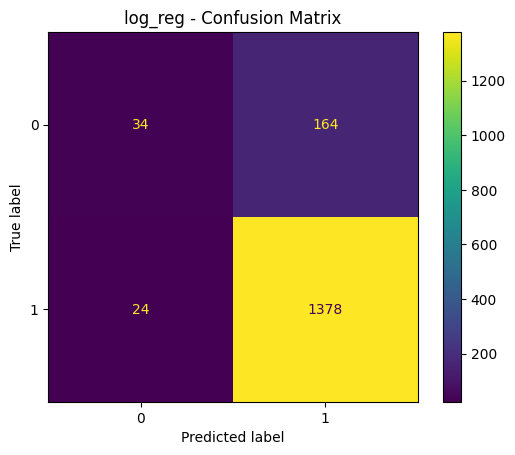

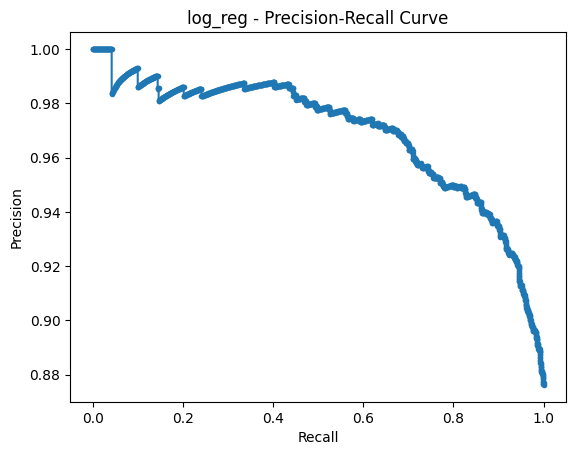

Saved log_reg -> C:\Capstone Project DS Subhajit Nandy\Digital Marketing Campaign Conversion\models\log_reg_best_model.joblib

=== Training decision_tree ===
Fitting 5 folds for each of 24 candidates, totalling 120 fits
decision_tree Test F1 Score: 0.9319
decision_tree Confusion Matrix:
[[  94  104]
 [  88 1314]]


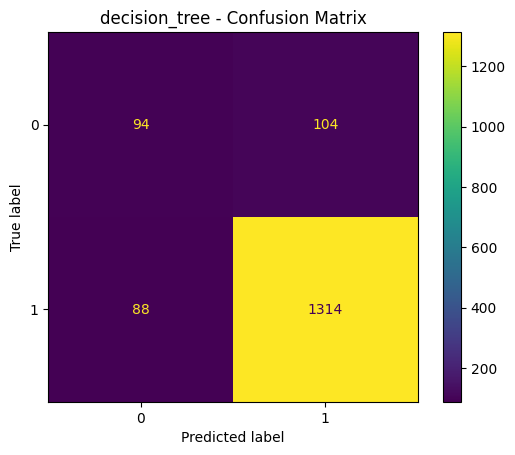

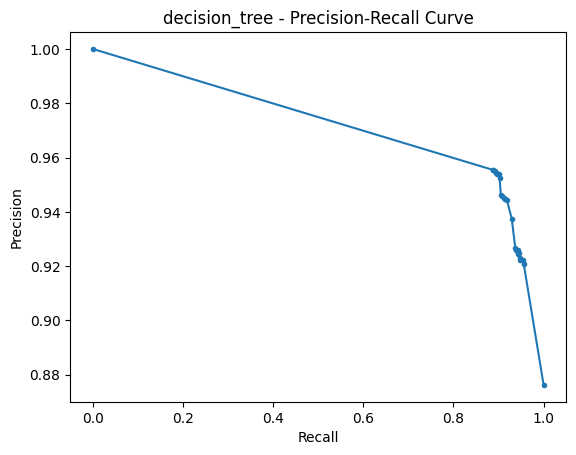

Saved decision_tree -> C:\Capstone Project DS Subhajit Nandy\Digital Marketing Campaign Conversion\models\decision_tree_best_model.joblib

=== Training random_forest ===
Fitting 5 folds for each of 6 candidates, totalling 30 fits
random_forest Test F1 Score: 0.9404
random_forest Confusion Matrix:
[[  36  162]
 [  14 1388]]


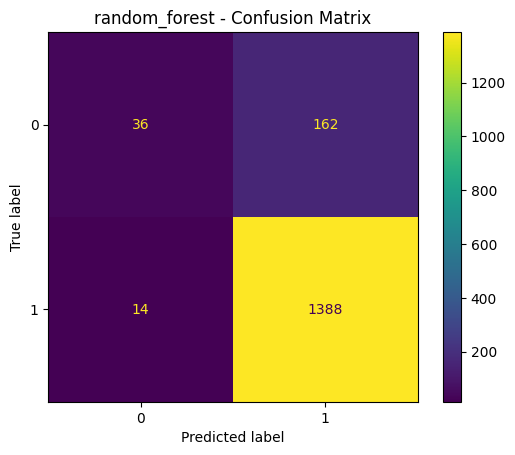

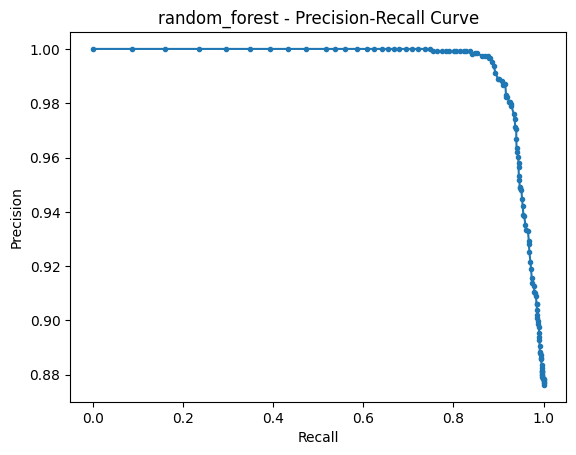

Saved random_forest -> C:\Capstone Project DS Subhajit Nandy\Digital Marketing Campaign Conversion\models\random_forest_best_model.joblib

=== Training gradient_boosting ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits
gradient_boosting Test F1 Score: 0.9613
gradient_boosting Confusion Matrix:
[[ 125   73]
 [  37 1365]]


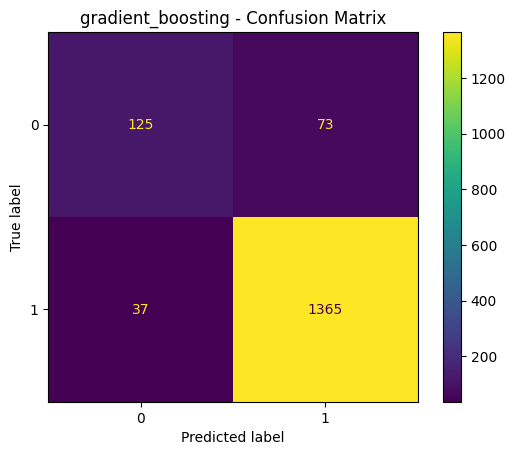

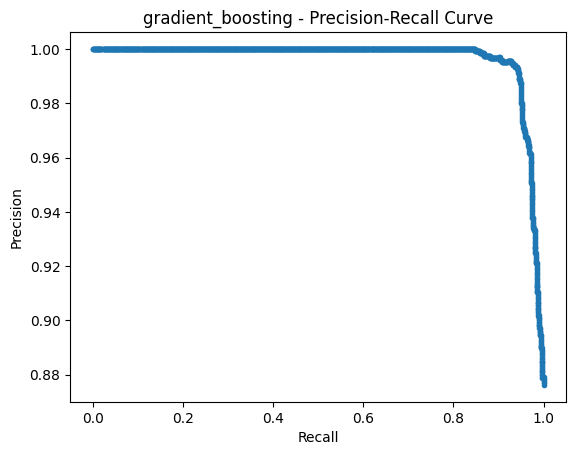

Saved gradient_boosting -> C:\Capstone Project DS Subhajit Nandy\Digital Marketing Campaign Conversion\models\gradient_boosting_best_model.joblib

=== Training svc ===
Fitting 5 folds for each of 4 candidates, totalling 20 fits
svc Test F1 Score: 0.9412
svc Confusion Matrix:
[[  42  156]
 [  17 1385]]


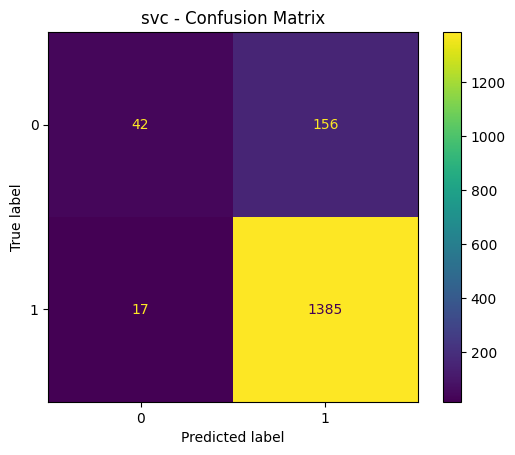

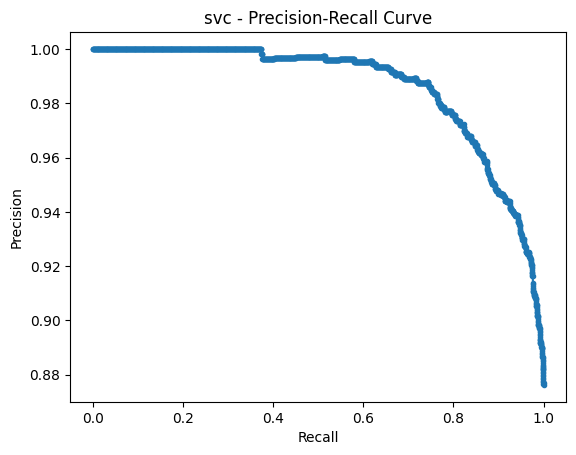

Saved svc -> C:\Capstone Project DS Subhajit Nandy\Digital Marketing Campaign Conversion\models\svc_best_model.joblib

=== Training xgboost ===
Fitting 5 folds for each of 32 candidates, totalling 160 fits


c:\Users\nsubh\.conda\envs\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


xgboost Test F1 Score: 0.9641
xgboost Confusion Matrix:
[[ 128   70]
 [  32 1370]]


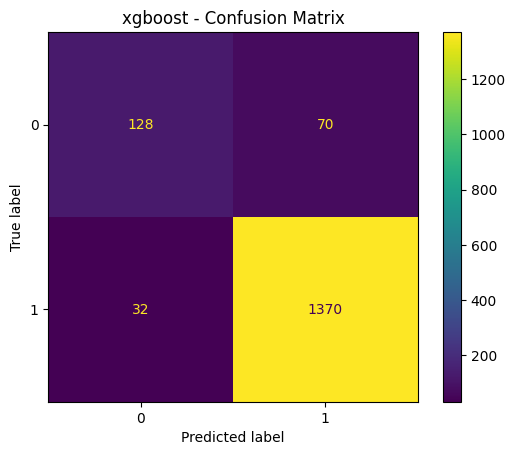

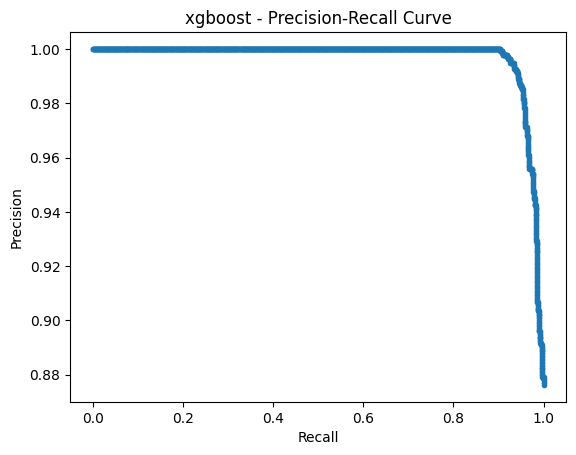

Saved xgboost -> C:\Capstone Project DS Subhajit Nandy\Digital Marketing Campaign Conversion\models\xgboost_best_model.joblib

Overall best model: xgboost with F1: 0.9641
Saved overall best model -> C:\Capstone Project DS Subhajit Nandy\Digital Marketing Campaign Conversion\models\best_model.joblib

=== Summary of all models ===
               model                                        best_params  \
0            log_reg  {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__so...   
1      decision_tree  {'clf__criterion': 'entropy', 'clf__max_depth'...   
2      random_forest  {'clf__max_depth': None, 'clf__n_estimators': ...   
3  gradient_boosting  {'clf__learning_rate': 0.1, 'clf__max_depth': ...   
4                svc              {'clf__C': 1.0, 'clf__kernel': 'rbf'}   
5            xgboost  {'clf__colsample_bytree': 1.0, 'clf__learning_...   

      cv_f1   test_f1                                         model_path  
0  0.939335  0.936141  C:\Capstone Project DS Subhajit Nandy\Digital

In [1]:
%pip install xgboost
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent))

from typing import Dict, List, Tuple
import json

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from xgboost import XGBClassifier

from src.config import (
    DATA_FILE,
    MODEL_DIR,
    BEST_MODEL_PATH,
    FEATURES_PATH,
    CV_FOLDS,
    SCORING,          # 'f1'
    SCORING_METRICS,  # ['accuracy', 'precision', 'recall', 'f1']
    N_JOBS,
)


# -------------------------------------------------------------------
# Data loading and preprocessing
# -------------------------------------------------------------------
def data_load(file_path) -> pd.DataFrame:
    """Load data from CSV file."""
    return pd.read_csv(file_path)


def split_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """Split data into train/test sets."""
    from sklearn.model_selection import train_test_split
    
    # Identify target column (last column by default)
    target_col = df.columns[-1]
    
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # 80/20 split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test


def build_preprocessor(X_train: pd.DataFrame):
    """Build preprocessor pipeline with imputation and encoding/scaling."""
    from sklearn.compose import ColumnTransformer
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    
    numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    
    numeric_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]
    )
    
    categorical_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
        ]
    )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols),
        ]
    )
    
    return preprocessor


# -------------------------------------------------------------------
# Model registry
# -------------------------------------------------------------------
def get_models_and_params() -> List[Tuple[str, object, Dict[str, List]]]:
    """Define candidate models and their hyperparameter grids."""
    models_and_params: List[Tuple[str, object, Dict[str, List]]] = []

    # Logistic Regression
    log_reg = LogisticRegression(max_iter=1000, random_state=42)
    log_reg_params = {
        "clf__C": [0.01, 0.1, 1.0],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"],
    }
    models_and_params.append(("log_reg", log_reg, log_reg_params))

    # Decision Tree
    dt = DecisionTreeClassifier(random_state=42)
    dt_params = {
        "clf__criterion": ["gini", "entropy"],
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10],
    }
    models_and_params.append(("decision_tree", dt, dt_params))

    # Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf_params = {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [None, 5, 10],
    }
    models_and_params.append(("random_forest", rf, rf_params))

    # Gradient Boosting
    gb = GradientBoostingClassifier(random_state=42)
    gb_params = {
        "clf__n_estimators": [100, 200],
        "clf__learning_rate": [0.05, 0.1],
        "clf__max_depth": [3, 5],
    }
    models_and_params.append(("gradient_boosting", gb, gb_params))

    # Support Vector Classifier
    svc = SVC(probability=True, random_state=42)
    svc_params = {
        "clf__C": [0.1, 1.0],
        "clf__kernel": ["rbf", "linear"],
    }
    models_and_params.append(("svc", svc, svc_params))

    # XGBoost
    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        use_label_encoder=False,
    )
    xgb_params = {
        "clf__n_estimators": [100, 200],
        "clf__learning_rate": [0.05, 0.1],
        "clf__max_depth": [3, 5],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0],
    }
    models_and_params.append(("xgboost", xgb, xgb_params))

    return models_and_params


# -------------------------------------------------------------------
# Performance evaluation helper
# -------------------------------------------------------------------
def evaluate_model(name: str, model, X_test, y_test):
    """Evaluate model using F1 score, confusion matrix, and precision-recall curve."""
    y_pred = model.predict(X_test)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]

    # F1 score
    f1 = metrics.f1_score(y_test, y_pred)
    print(f"{name} Test F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    print(f"{name} Confusion Matrix:\n{cm}")

    # Plot confusion matrix
    metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # Precision-Recall Curve
    if y_proba is not None:
        precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_proba)
        plt.plot(recall, precision, marker='.')
        plt.title(f"{name} - Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.show()

    return f1


# -------------------------------------------------------------------
# Training logic
# -------------------------------------------------------------------
def train_and_select_model() -> pd.DataFrame:
    """Train models and select the best one based on F1 score."""
    MODEL_DIR.mkdir(parents=True, exist_ok=True)

    print("Loading cleaned data ->", DATA_FILE)
    df = data_load(DATA_FILE)
    print("Data shape:", df.shape)
    print("Columns:", df.columns.tolist())

    # Split data
    X_train, X_test, y_train, y_test = split_data(df)

    # Save feature list for inference-time alignment
    feature_cols = X_train.columns.tolist()
    with open(FEATURES_PATH, "w", encoding="utf-8") as f:
        json.dump(feature_cols, f, ensure_ascii=False, indent=2)
    print(f"Saved feature list ({len(feature_cols)}) to {FEATURES_PATH}")

    print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

    preprocessor = build_preprocessor(X_train)
    print("Preprocessor built.")

    models_and_params = get_models_and_params()

    best_overall = None
    best_score = -np.inf
    best_name = None
    results: List[Dict] = []

    for name, estimator, param_grid in models_and_params:
        try:
            print(f"\n=== Training {name} ===")

            pipeline = Pipeline(
                steps=[
                    ("preprocess", preprocessor),
                    ("clf", estimator),
                ]
            )

            grid = GridSearchCV(
                estimator=pipeline,
                param_grid=param_grid,
                cv=CV_FOLDS,
                scoring=SCORING,   # F1 from config
                n_jobs=N_JOBS,
                verbose=1,
            )

            grid.fit(X_train, y_train)

            best = grid.best_estimator_
            cv_f1 = grid.best_score_

            # Evaluate with extended metrics
            test_f1 = evaluate_model(name, best, X_test, y_test)

            # Save model
            model_path = MODEL_DIR / f"{name}_best_model.joblib"
            joblib.dump(best, model_path)
            print(f"Saved {name} -> {model_path}")

            results.append(
                {
                    "model": name,
                    "best_params": grid.best_params_,
                    "cv_f1": cv_f1,
                    "test_f1": test_f1,
                    "model_path": str(model_path),
                }
            )
            # Update overall best
            if test_f1 > best_score:
                best_score = test_f1
                best_overall = best
                best_name = name
        except Exception as e:
            print(f"Error training {name}: {e}")
    # Save overall best model
    if best_overall is not None:
        joblib.dump(best_overall, BEST_MODEL_PATH)
        print(f"\nOverall best model: {best_name} with F1: {best_score:.4f}")
        print(f"Saved overall best model -> {BEST_MODEL_PATH}")
    results_df = pd.DataFrame(results)
    return results_df
if __name__ == "__main__":
    results_df = train_and_select_model()
    print("\n=== Summary of all models ===")
    print(results_df)


               